In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import torch
import torch.nn as nn
from matplotlib.colors import Normalize

#### Get the data and visualize it

In [2]:
file_path = './burgers.npy' 
# change path accordingly

In [3]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)

C:\Users\jonas\AppData\Local\Temp\ipykernel_10068\3600534733.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


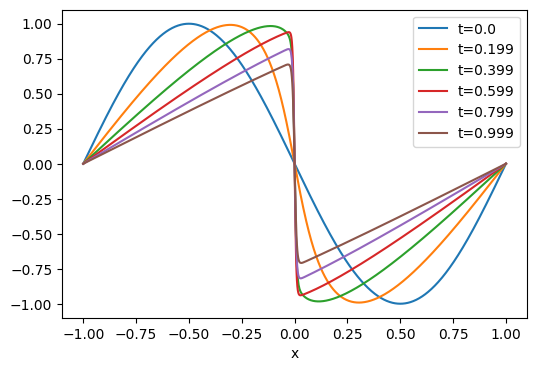

In [4]:
# Visualize some of the data, for some values of t
fig, ax = plt.subplots(1,figsize=(6,4))
for j in [0,199,399,599,799,999]:
    ax.plot(np.linspace(-1, 1, 1000), usol[j,:], label=f't={j/usol.shape[0]}')
ax.set_xlabel('x')
ax.legend()
fig.show()

# the first dimension is t (usol[t,:] is all x at time t)
# second dimension is x 

#### Neural Network Architecture

In [5]:
class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

#### Get Collocation points in $x\in [-1,1]$ and $t\in [0,1]$

In [6]:
def generate_latin_hyper_c_sampling(Nd=10000):
    sampler = qmc.LatinHypercube(d=2)
    sample_pos = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg = sampler.random(n=Nd//2) # [0,1)^2
    sample_neg[:,1] = -sample_neg[:,1]

    return np.vstack([sample_pos, sample_neg])

In [7]:
collocation_p = generate_latin_hyper_c_sampling(10**4)

In [8]:
collocation_p

array([[ 0.83888309,  0.49773621],
       [ 0.63316   ,  0.63510358],
       [ 0.60402217,  0.17289124],
       ...,
       [ 0.82278909, -0.5663637 ],
       [ 0.99068319, -0.19689186],
       [ 0.7145566 , -0.20975917]])

In [9]:
# first column is in range [0,1] (represents t)
assert collocation_p[:,0].min() > 0
assert collocation_p[:,0].max() < 1

# second column is in range [-1,1] (represents x)
assert collocation_p[:,1].min() > -1
assert collocation_p[:,1].max() < 1

C:\Users\jonas\AppData\Local\Temp\ipykernel_10068\1262115449.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


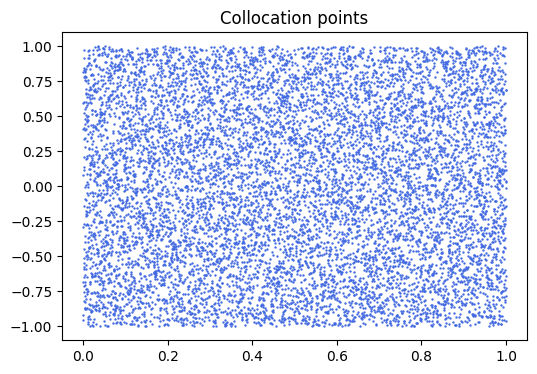

In [10]:
fig, ax = plt.subplots(1,figsize=(6,4))
ax.scatter(collocation_p[:,0], collocation_p[:,1], s=0.5, color='royalblue')
ax.set_title('Collocation points')
fig.show()

### Get training data

In [11]:
def get_train_data(n, t, usol, noise=5e-3):
    '''
    Return n training data at a constant time t, along the whole x axis with an additive 
    noise ~ N(0,1)*eps
    '''
    t_index = int(t*usol.shape[1])
    
    x_indices = np.arange(0, usol.shape[1], usol.shape[1]//n)
    u_vals = usol[t_index, x_indices]
    u_vals = u_vals.reshape(-1,1)
    
    x_vals = ((x_indices * (2/1000)) -1)
    x_vals = x_vals.reshape(-1,1)
    t_vals = np.array([t]*x_vals.shape[0])
    t_vals = t_vals.reshape(-1,1)
    
    u_vals += (np.random.normal(loc=0.0, scale=1.0, size=u_vals.shape[0]) * noise).reshape(-1,1)
    
    return np.concatenate([t_vals, x_vals], axis=1), u_vals

In [12]:
train_data_t05, target_t05 = get_train_data(100, 0.5, usol, noise=5e-3)
train_data_t095, target_t095 = get_train_data(100, 0.95, usol, noise=5e-3)
train_data_t015, target_t015 = get_train_data(100, 0.15, usol, noise=5e-3)
train_data_t025, target_t025 = get_train_data(100, 0.25, usol, noise=5e-3)

# concatenate all training data
train_data = np.concatenate([train_data_t05, train_data_t095, train_data_t015, train_data_t025], axis=0)
train_targets = np.concatenate([target_t05, target_t095, target_t015, target_t025], axis=0)

C:\Users\jonas\AppData\Local\Temp\ipykernel_10068\1838387595.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


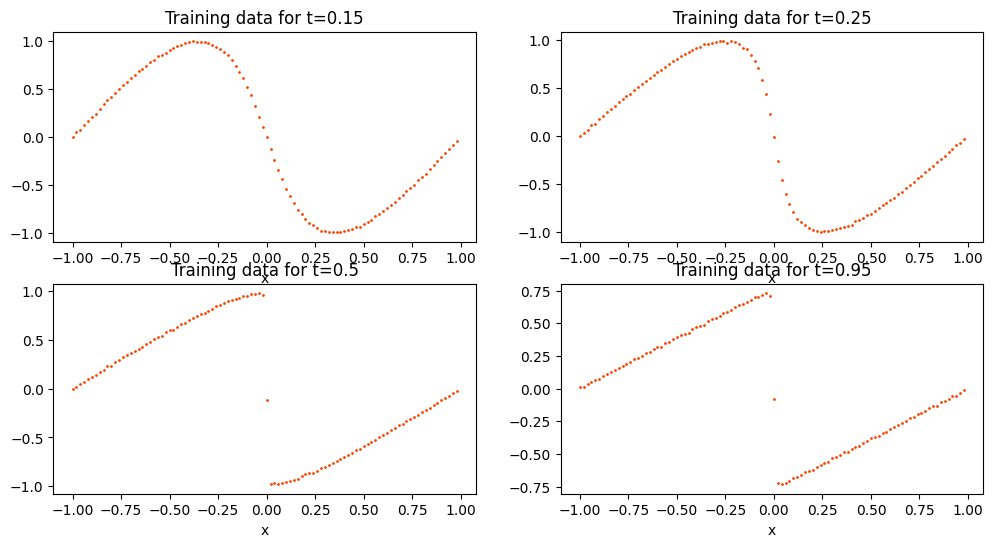

In [13]:
# Visualize the training data
fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].scatter(train_data_t015[:,1], target_t015[:,0], s=1, color='orangered')
ax[0,0].set_title('Training data for t=0.15')
ax[0,0].set_xlabel('x')

ax[0,1].scatter(train_data_t025[:,1], target_t025[:,0], s=1, color='orangered')
ax[0,1].set_title('Training data for t=0.25')
ax[0,1].set_xlabel('x')

ax[1,0].scatter(train_data_t05[:,1], target_t05[:,0], s=1, color='orangered')
ax[1,0].set_title('Training data for t=0.5')
ax[1,0].set_xlabel('x')

ax[1,1].scatter(train_data_t095[:,1], target_t095[:,0], s=1, color='orangered')
ax[1,1].set_title('Training data for t=0.95')
ax[1,1].set_xlabel('x')
fig.show()

In [14]:
print(train_data.shape)
assert train_data[:,0].min() >= 0
assert train_data[:,0].max() <= 1
assert train_data[:,1].min() >= -1
assert train_data[:,1].max() <= 1

(400, 2)


In [15]:
def get_boundary_points(n=100):
    '''
    Returns n data for each boundary and initial conditions
    '''
    sampler = qmc.LatinHypercube(d=1)
    sample_pos = sampler.random(4*n)
    
    # initial conditions
    u_initial = lambda x: -np.sin(np.pi * x)
    
    # (t,1) boundary
    top_b = sample_pos[:100]
    top_b = np.concatenate([top_b, np.ones_like(top_b)],axis=1)
    top_b_target = np.zeros((top_b.shape[0],1))
    # (t, -1) boundary
    bot_b = sample_pos[100:200]
    bot_b = np.concatenate([bot_b, np.ones_like(bot_b)*-1],axis=1)
    bot_b_target = np.zeros((bot_b.shape[0],1))
    
    # initial conditions
    x_b = sample_pos[200:300]
    x_b = np.concatenate([np.zeros_like(x_b), x_b],axis=1)
    x_b_target = u_initial(x_b[:,1]).reshape(-1,1)

    
    negx_b = -sample_pos[300:]
    negx_b = np.concatenate([np.zeros_like(negx_b), negx_b],axis=1)
    negx_b_target = u_initial(negx_b[:,1]).reshape(-1,1)
    
    return np.concatenate([top_b, bot_b, x_b, negx_b],axis=0), np.concatenate([top_b_target, 
                                                                               bot_b_target, 
                                                                               x_b_target, 
                                                                              negx_b_target], axis=0)

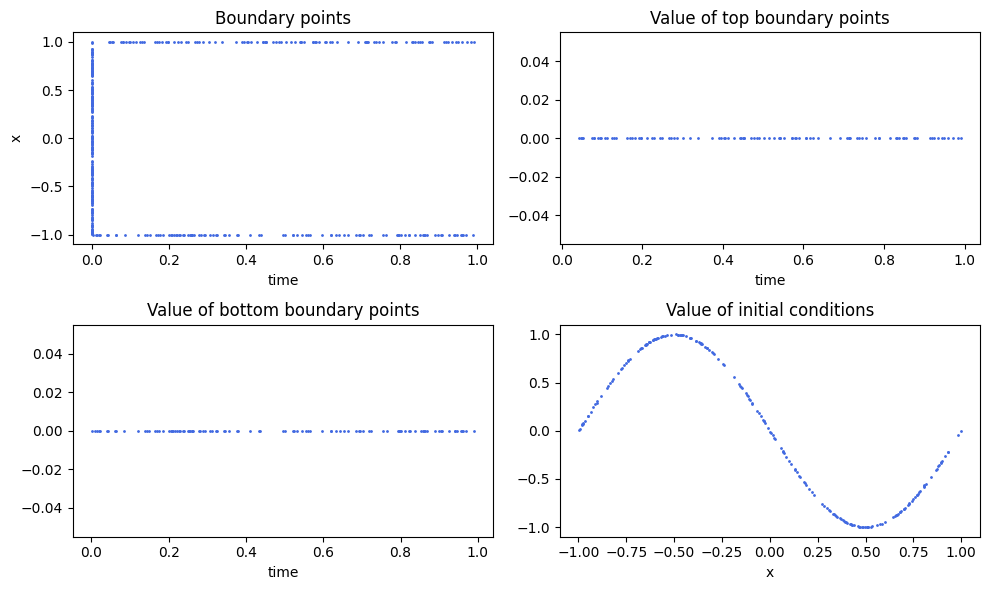

In [16]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

boundary_points, boundary_targets = get_boundary_points(100)

ax[0,0].scatter(boundary_points[:,0], boundary_points[:,1], s=1.0, color='royalblue')
ax[0,0].set_title('Boundary points')
ax[0,0].set_xlabel('time')
ax[0,0].set_ylabel('x')

ax[0,1].scatter(boundary_points[:100,0], boundary_targets[:100], s=1.0, color='royalblue')
ax[0,1].set_title('Value of top boundary points')
ax[0,1].set_xlabel('time')

ax[1,0].scatter(boundary_points[100:200,0], boundary_targets[100:200], s=1.0, color='royalblue')
ax[1,0].set_title('Value of bottom boundary points')
ax[1,0].set_xlabel('time')

ax[1,1].scatter(boundary_points[200:,1], boundary_targets[200:], s=1.0, color='royalblue')
ax[1,1].set_title('Value of initial conditions')
ax[1,1].set_xlabel('x')

fig.tight_layout()

#### Training

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# put data on device
collocation_p = torch.Tensor(collocation_p).to(device).requires_grad_(True)
boundary_points = torch.Tensor(boundary_points).to(device)
boundary_targets = torch.Tensor(boundary_targets).to(device)
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

In [18]:
# if you want to use mini-batches (it slows down a lot, CPU becomes a bottleneck on Kaggle)
# import torch.utils.data as data_utils

# collocation_dataset = data_utils.TensorDataset(collocation_p)
# collocation_dataloader = data_utils.DataLoader(collocation_dataset, batch_size=2048, shuffle=True)

In [19]:
# initialize the networks and put them on the device
u = U(2,1, [20]*8)
u = u.to(device)

f = F(3,1, [20]*8)
f = f.to(device)

In [20]:
# Known viscosity hyperparam
v = 1 / (100 * np.pi)

In [21]:
def get_loss(boundary_points, boundary_targets, collocation_p, train_data, train_targets, lambdas):
    '''
    Computes and returns the boundary, physics and data loss.
    '''
    lambda1, lambda2, lambda3 = lambdas[0], lambdas[1], lambdas[2]
    # boundary loss -------
    u_b = u(boundary_points)
    loss1 = nn.MSELoss()(u_b, boundary_targets)
    

    # Physics loss -------
    u_p = u(collocation_p)
    dudxt = torch.autograd.grad(u_p, collocation_p, torch.ones_like(u_p), create_graph=True)[0]
    dudt = dudxt[:,0]
    dudx = dudxt[:,1]
    
    du2dx2 = torch.autograd.grad(dudxt, collocation_p, 
                                 torch.ones_like(dudxt), create_graph=True)[0][:,1]
    
    f_input = torch.cat([u_p,dudt.reshape(-1,1),dudx.reshape(-1,1)], axis=1)
    f_p = f(f_input)
    
    loss2 = nn.MSELoss()(-dudt.reshape(-1,1) + f_p + v * du2dx2.reshape(-1,1), torch.zeros_like(dudt.reshape(-1,1)))
    
    # Datapoint loss -------
    u_n = u(train_data)
    loss3 = nn.MSELoss()(u_n, train_targets)
    
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    return loss, loss1, loss2, loss3

In [22]:
def plot_solution(usol, u, f, mesh_size=10**2):
    '''
    Plot the surrogate solution, slices of the solution and the unknown term.
    '''
    
    # Compute u, dudx and F(u, dudx, dudt) to plot the true, estimated and learned unknown component N_k
    # The unknown component should be: -u * dudx
    x_points = (torch.linspace(-1,1,1000)).reshape(-1,1)
    t_points = (torch.ones_like(x_points)*0.75).reshape(-1,1)
    tx_points = torch.cat([t_points, x_points], axis=1).to(device).requires_grad_(True)
    
    u_plot = u(tx_points)
    
    dudxt_plot = torch.autograd.grad(u_plot, tx_points, torch.ones_like(u_plot), create_graph=True)[0]
    dudt_plot = dudxt_plot[:,0].reshape(-1,1)
    dudx_plot = dudxt_plot[:,1].reshape(-1,1)
    f_input_plot = torch.cat([u_plot, dudt_plot,dudx_plot], axis=1)
    f_plot = f(f_input_plot)
    
    # Compute dudx from the true solution u using finite difference
    # We consider the timestep t=0.75 so that the result is interpretable
    # and it is a timestep without any training data 
    true_u = usol[750,:]
    dudx_upwind = np.zeros((1000,1))
    
    dx = 2 / 1000
    for i in range(1, true_u.shape[0]-1):
            if true_u[i] >= 0:
                    dudx_upwind[i] = (true_u[i] - true_u[i-1]) / dx
            else:
                    dudx_upwind[i] = (true_u[i+1] - true_u[i]) / dx
    
    with torch.no_grad():
            # Get a meshgrid of points to display an image of the solution u in the
            # domain x=[-1,1] and t=[0,1]
            t_phys = np.linspace(0, 1, mesh_size)
            x_phys = np.linspace(-1, 1, mesh_size)
            x_mesh, t_mesh = np.meshgrid(x_phys, t_phys)

            coordinates = np.vstack((t_mesh.flatten(), x_mesh.flatten())).T
            coordinates = torch.Tensor(coordinates).to(device)
            
            u_p = u(coordinates).detach().cpu().numpy()
            u_mesh = u_p.reshape(x_mesh.shape)

            data_min = np.min(u_p)
            data_max = np.max(u_p)

            # Contour plot
            fig, ax = plt.subplots(2,2,figsize=(12,6))
            norm = Normalize(vmin=data_min, vmax=data_max)
            img = ax[0,0].imshow(u_mesh.T, cmap='viridis', 
                                 aspect='auto', 
                                 extent=[0, 1, 1, -1])
            fig.colorbar(img, ax=ax[0,0])

            ax[0,0].set_xlabel('t')
            ax[0,0].set_ylabel('x')
            ax[0,0].set_title('Contour plot of the Viscous Burgers Equation Approximation')
            
            # Slices
            # Visualize some of u predictions, for some values of t
            colors = ['royalblue', 'forestgreen', 'darkorange', 'firebrick']
            for i,(j,k) in enumerate(zip([0,500,750,999], [0,50,75,99])):
                ax[0,1].plot(np.linspace(-1, 1, 1000), usol[j,:], 
                             label=f't={j/usol.shape[0]}', color=colors[i])
                ax[0,1].plot(np.linspace(-1, 1, 100), 
                             u_mesh[k,:], linestyle='--', color=colors[i])
            ax[0,1].set_xlabel('x')
            ax[0,1].legend()
            fig.show()
            
            # plot the unknown term learned by F vs the true interaction
            expected = -(u_plot * dudx_plot).detach().cpu().numpy()
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), expected[375:625], label='Expected unknown')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), f_plot.detach().cpu().numpy()[375:625], label='F', linestyle='--')
            ax[1,0].plot(np.linspace(-0.25, 0.25, 250), (-true_u.reshape(-1,1)*dudx_upwind)[375:625], label='True unknown')
            ax[1,0].legend()
            ax[1,0].set_title('Unknown term at time t=0.75')

            
            plt.show()
            return fig
    

Iteration 0
[0/10001] Boundary L: 0.2818426191806793, Phys L: 0.04320209473371506, Data L: 0.4121588170528412


C:\Users\jonas\AppData\Local\Temp\ipykernel_10068\2272388903.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


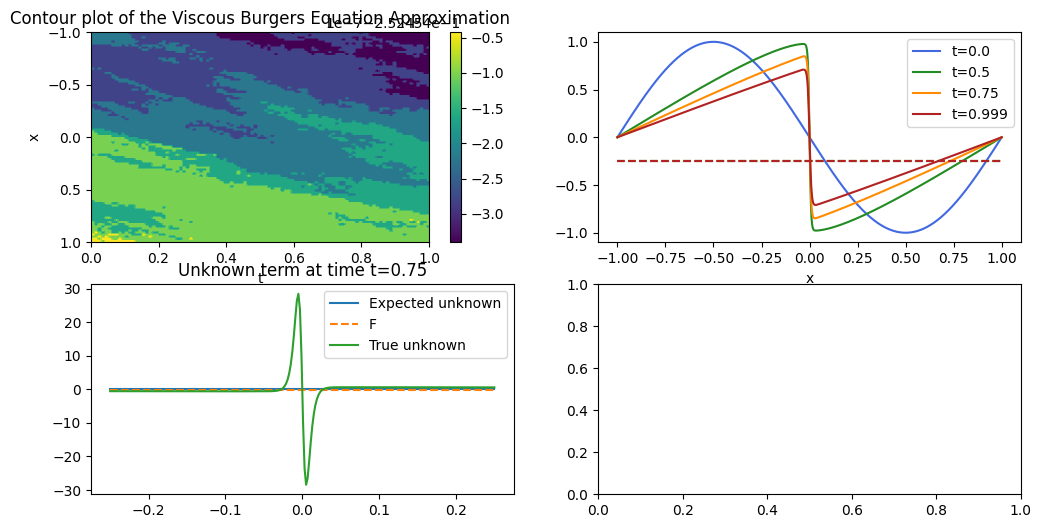

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

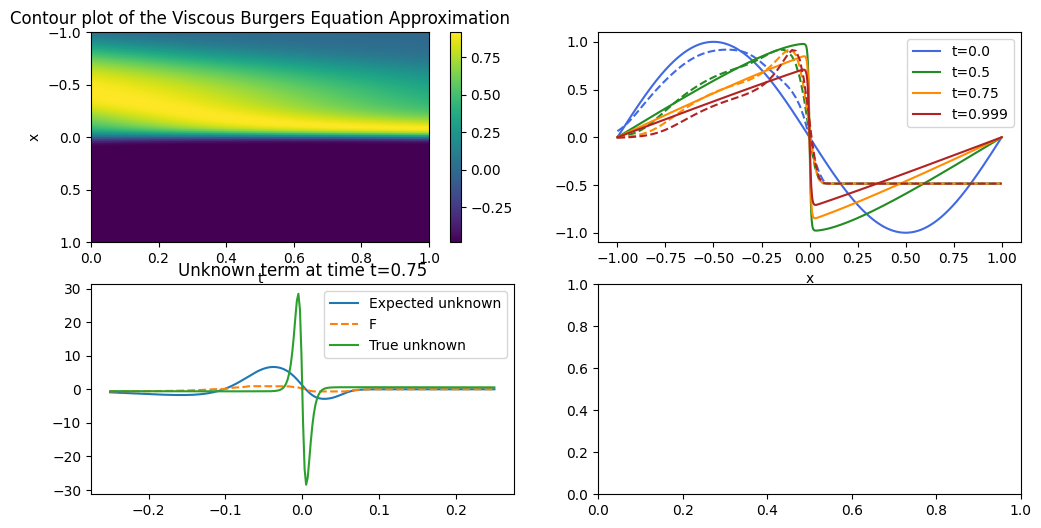

Iteration 1001
Iteration 1002
Iteration 1003
Iteration 1004
Iteration 1005
Iteration 1006
Iteration 1007
Iteration 1008
Iteration 1009
Iteration 1010
Iteration 1011
Iteration 1012
Iteration 1013
Iteration 1014
Iteration 1015
Iteration 1016
Iteration 1017
Iteration 1018
Iteration 1019
Iteration 1020
Iteration 1021
Iteration 1022
Iteration 1023
Iteration 1024
Iteration 1025
Iteration 1026
Iteration 1027
Iteration 1028
Iteration 1029
Iteration 1030
Iteration 1031
Iteration 1032
Iteration 1033
Iteration 1034
Iteration 1035
Iteration 1036
Iteration 1037
Iteration 1038
Iteration 1039
Iteration 1040
Iteration 1041
Iteration 1042
Iteration 1043
Iteration 1044
Iteration 1045
Iteration 1046
Iteration 1047
Iteration 1048
Iteration 1049
Iteration 1050
Iteration 1051
Iteration 1052
Iteration 1053
Iteration 1054
Iteration 1055
Iteration 1056
Iteration 1057
Iteration 1058
Iteration 1059
Iteration 1060
Iteration 1061
Iteration 1062
Iteration 1063
Iteration 1064
Iteration 1065
Iteration 1066
Iteration 

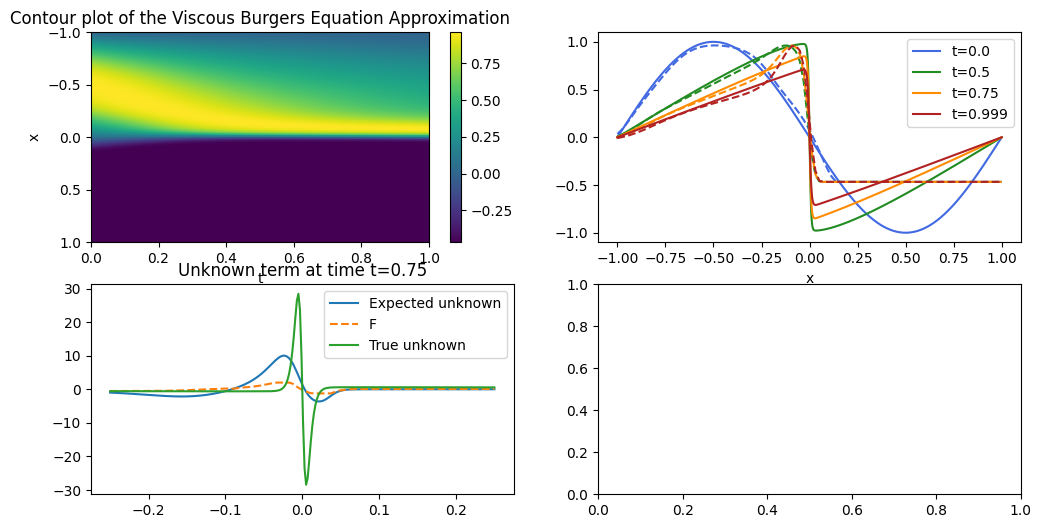

Iteration 2001
Iteration 2002
Iteration 2003
Iteration 2004
Iteration 2005
Iteration 2006
Iteration 2007
Iteration 2008
Iteration 2009
Iteration 2010
Iteration 2011
Iteration 2012
Iteration 2013
Iteration 2014
Iteration 2015
Iteration 2016
Iteration 2017
Iteration 2018
Iteration 2019
Iteration 2020
Iteration 2021
Iteration 2022
Iteration 2023
Iteration 2024
Iteration 2025
Iteration 2026
Iteration 2027
Iteration 2028
Iteration 2029
Iteration 2030
Iteration 2031
Iteration 2032
Iteration 2033
Iteration 2034
Iteration 2035
Iteration 2036
Iteration 2037
Iteration 2038
Iteration 2039
Iteration 2040
Iteration 2041
Iteration 2042
Iteration 2043
Iteration 2044
Iteration 2045
Iteration 2046
Iteration 2047
Iteration 2048
Iteration 2049
Iteration 2050
Iteration 2051
Iteration 2052
Iteration 2053
Iteration 2054
Iteration 2055
Iteration 2056
Iteration 2057
Iteration 2058
Iteration 2059
Iteration 2060
Iteration 2061
Iteration 2062
Iteration 2063
Iteration 2064
Iteration 2065
Iteration 2066
Iteration 

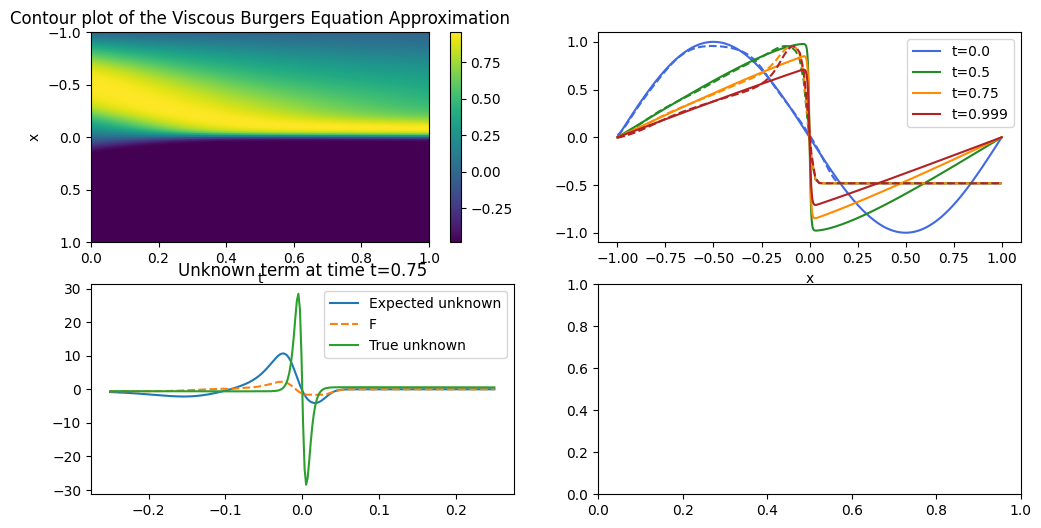

Iteration 3001
Iteration 3002
Iteration 3003
Iteration 3004
Iteration 3005
Iteration 3006
Iteration 3007
Iteration 3008
Iteration 3009
Iteration 3010
Iteration 3011
Iteration 3012
Iteration 3013
Iteration 3014
Iteration 3015
Iteration 3016
Iteration 3017
Iteration 3018
Iteration 3019
Iteration 3020
Iteration 3021
Iteration 3022
Iteration 3023
Iteration 3024
Iteration 3025
Iteration 3026
Iteration 3027
Iteration 3028
Iteration 3029
Iteration 3030
Iteration 3031
Iteration 3032
Iteration 3033
Iteration 3034
Iteration 3035
Iteration 3036
Iteration 3037
Iteration 3038
Iteration 3039
Iteration 3040
Iteration 3041
Iteration 3042
Iteration 3043
Iteration 3044
Iteration 3045
Iteration 3046
Iteration 3047
Iteration 3048
Iteration 3049
Iteration 3050
Iteration 3051
Iteration 3052
Iteration 3053
Iteration 3054
Iteration 3055
Iteration 3056
Iteration 3057
Iteration 3058
Iteration 3059
Iteration 3060
Iteration 3061
Iteration 3062
Iteration 3063
Iteration 3064
Iteration 3065
Iteration 3066
Iteration 

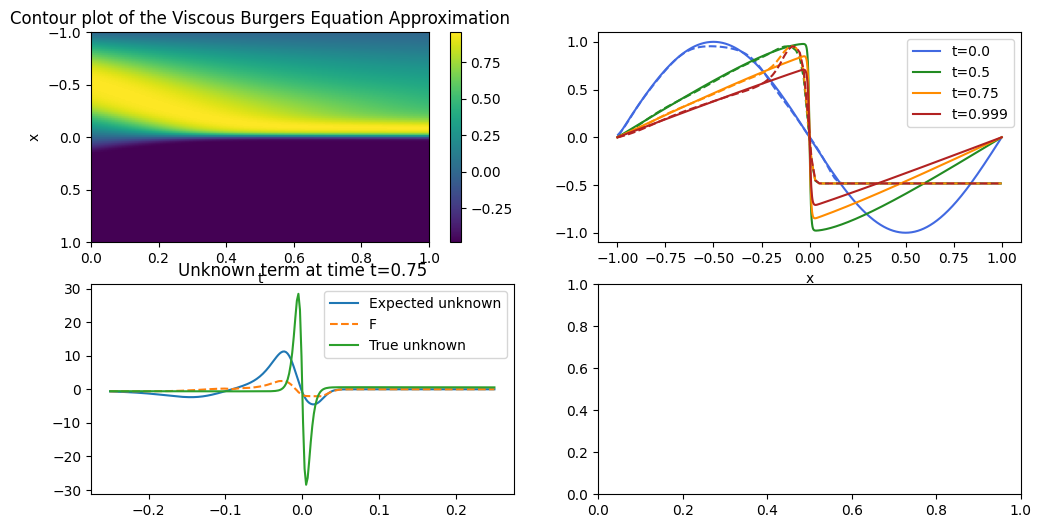

Iteration 4001
Iteration 4002
Iteration 4003
Iteration 4004
Iteration 4005
Iteration 4006
Iteration 4007
Iteration 4008
Iteration 4009
Iteration 4010
Iteration 4011
Iteration 4012
Iteration 4013
Iteration 4014
Iteration 4015
Iteration 4016
Iteration 4017
Iteration 4018
Iteration 4019
Iteration 4020
Iteration 4021
Iteration 4022
Iteration 4023
Iteration 4024
Iteration 4025
Iteration 4026
Iteration 4027
Iteration 4028
Iteration 4029
Iteration 4030
Iteration 4031
Iteration 4032
Iteration 4033
Iteration 4034
Iteration 4035
Iteration 4036
Iteration 4037
Iteration 4038
Iteration 4039
Iteration 4040
Iteration 4041
Iteration 4042
Iteration 4043
Iteration 4044
Iteration 4045
Iteration 4046
Iteration 4047
Iteration 4048
Iteration 4049
Iteration 4050
Iteration 4051
Iteration 4052
Iteration 4053
Iteration 4054
Iteration 4055
Iteration 4056
Iteration 4057
Iteration 4058
Iteration 4059
Iteration 4060
Iteration 4061
Iteration 4062
Iteration 4063
Iteration 4064
Iteration 4065
Iteration 4066
Iteration 

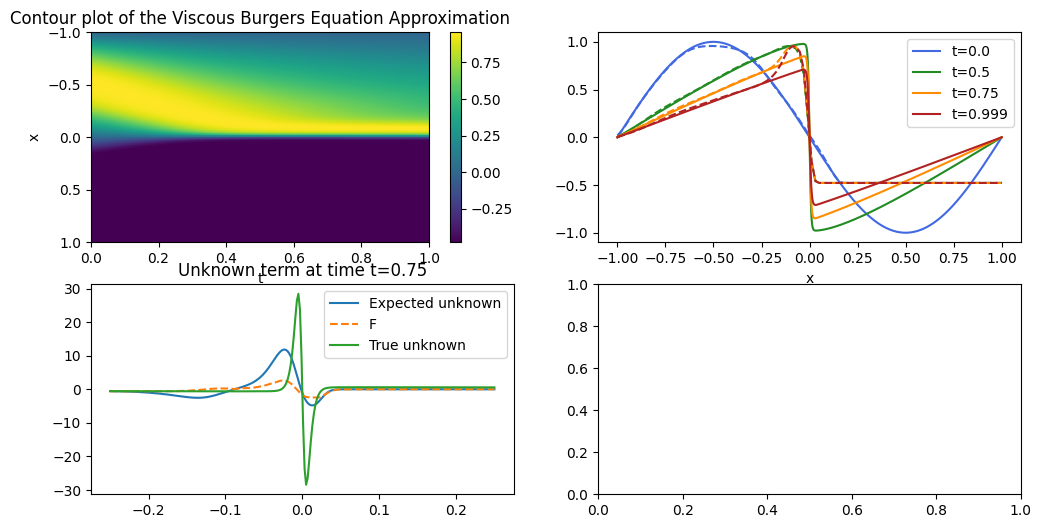

Iteration 5001
Iteration 5002
Iteration 5003
Iteration 5004
Iteration 5005
Iteration 5006
Iteration 5007
Iteration 5008
Iteration 5009
Iteration 5010
Iteration 5011
Iteration 5012
Iteration 5013
Iteration 5014
Iteration 5015
Iteration 5016
Iteration 5017
Iteration 5018
Iteration 5019
Iteration 5020
Iteration 5021
Iteration 5022
Iteration 5023
Iteration 5024
Iteration 5025
Iteration 5026
Iteration 5027
Iteration 5028
Iteration 5029
Iteration 5030
Iteration 5031
Iteration 5032
Iteration 5033
Iteration 5034
Iteration 5035
Iteration 5036
Iteration 5037
Iteration 5038
Iteration 5039
Iteration 5040
Iteration 5041
Iteration 5042
Iteration 5043
Iteration 5044
Iteration 5045
Iteration 5046
Iteration 5047
Iteration 5048
Iteration 5049
Iteration 5050
Iteration 5051
Iteration 5052
Iteration 5053
Iteration 5054
Iteration 5055
Iteration 5056
Iteration 5057
Iteration 5058
Iteration 5059
Iteration 5060
Iteration 5061
Iteration 5062
Iteration 5063
Iteration 5064
Iteration 5065
Iteration 5066
Iteration 

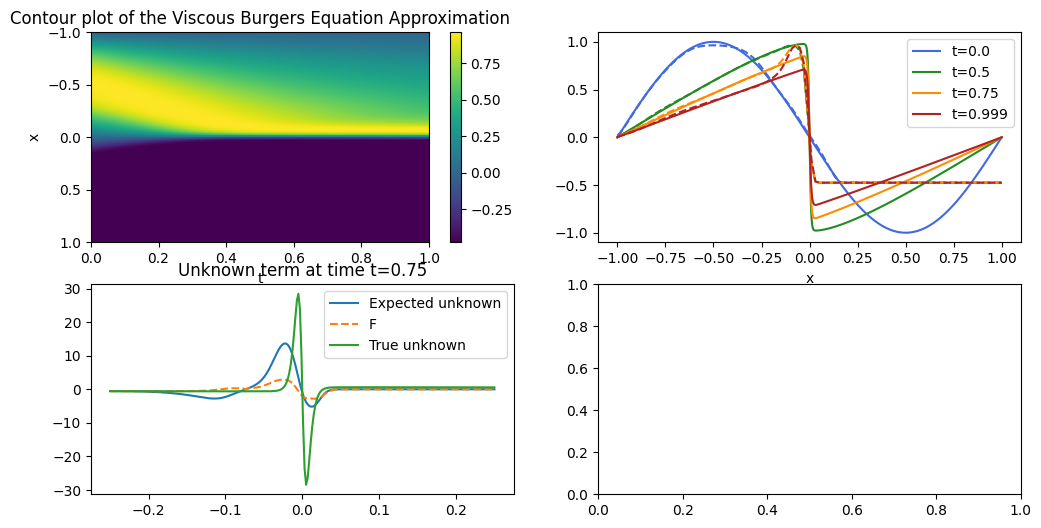

Iteration 6001
Iteration 6002
Iteration 6003
Iteration 6004
Iteration 6005
Iteration 6006
Iteration 6007
Iteration 6008
Iteration 6009
Iteration 6010
Iteration 6011
Iteration 6012
Iteration 6013
Iteration 6014
Iteration 6015
Iteration 6016
Iteration 6017
Iteration 6018
Iteration 6019
Iteration 6020
Iteration 6021
Iteration 6022
Iteration 6023
Iteration 6024
Iteration 6025
Iteration 6026
Iteration 6027
Iteration 6028
Iteration 6029
Iteration 6030
Iteration 6031
Iteration 6032
Iteration 6033
Iteration 6034
Iteration 6035
Iteration 6036
Iteration 6037
Iteration 6038
Iteration 6039
Iteration 6040
Iteration 6041
Iteration 6042
Iteration 6043
Iteration 6044
Iteration 6045
Iteration 6046
Iteration 6047
Iteration 6048
Iteration 6049
Iteration 6050
Iteration 6051
Iteration 6052
Iteration 6053
Iteration 6054
Iteration 6055
Iteration 6056
Iteration 6057
Iteration 6058
Iteration 6059
Iteration 6060
Iteration 6061
Iteration 6062
Iteration 6063
Iteration 6064
Iteration 6065
Iteration 6066
Iteration 

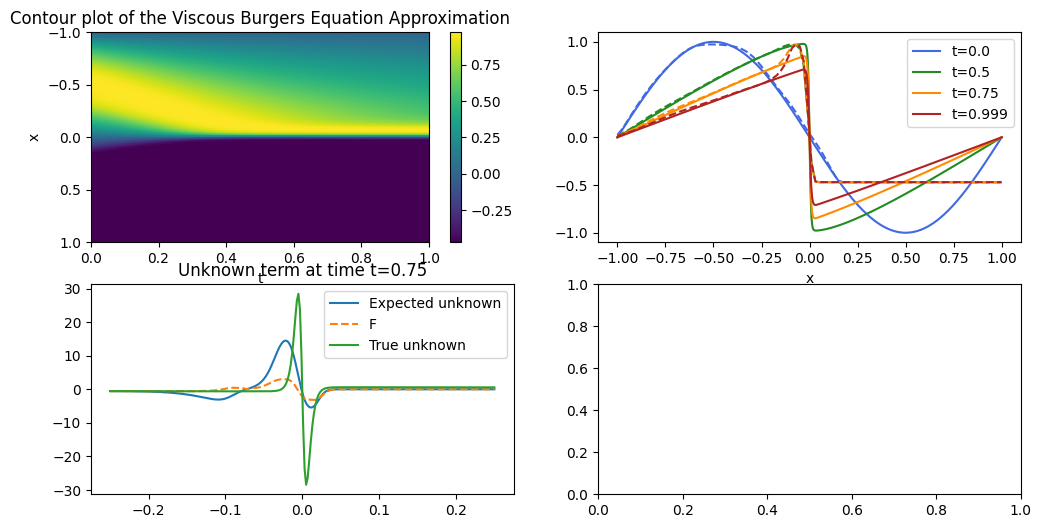

Iteration 7001
Iteration 7002
Iteration 7003
Iteration 7004
Iteration 7005
Iteration 7006
Iteration 7007
Iteration 7008
Iteration 7009
Iteration 7010
Iteration 7011
Iteration 7012
Iteration 7013
Iteration 7014
Iteration 7015
Iteration 7016
Iteration 7017
Iteration 7018
Iteration 7019
Iteration 7020
Iteration 7021
Iteration 7022
Iteration 7023
Iteration 7024
Iteration 7025
Iteration 7026
Iteration 7027
Iteration 7028
Iteration 7029
Iteration 7030
Iteration 7031
Iteration 7032
Iteration 7033
Iteration 7034
Iteration 7035
Iteration 7036
Iteration 7037
Iteration 7038
Iteration 7039
Iteration 7040
Iteration 7041
Iteration 7042
Iteration 7043
Iteration 7044
Iteration 7045
Iteration 7046
Iteration 7047
Iteration 7048
Iteration 7049
Iteration 7050
Iteration 7051
Iteration 7052
Iteration 7053
Iteration 7054
Iteration 7055
Iteration 7056
Iteration 7057
Iteration 7058
Iteration 7059
Iteration 7060
Iteration 7061
Iteration 7062
Iteration 7063
Iteration 7064
Iteration 7065
Iteration 7066
Iteration 

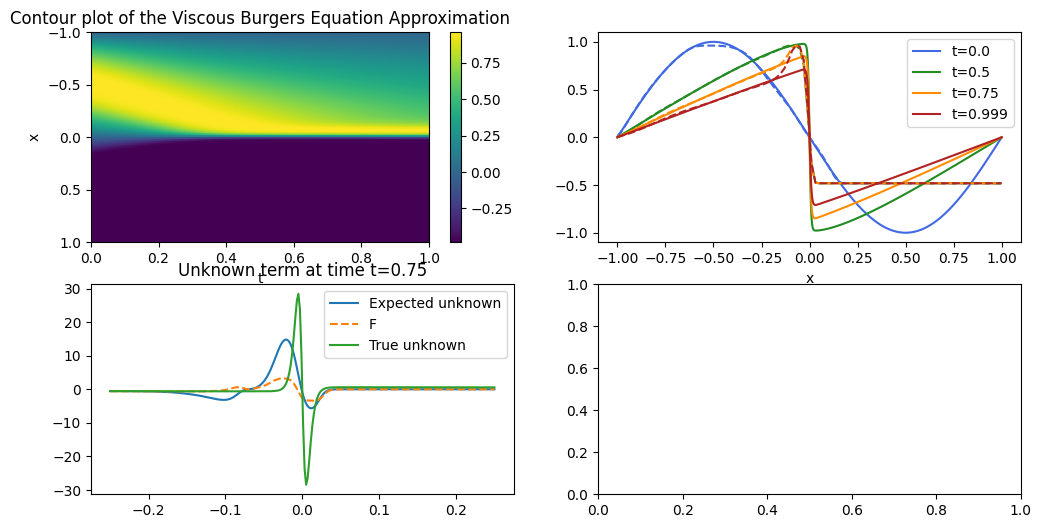

Iteration 8001
Iteration 8002
Iteration 8003
Iteration 8004
Iteration 8005
Iteration 8006
Iteration 8007
Iteration 8008
Iteration 8009
Iteration 8010
Iteration 8011
Iteration 8012
Iteration 8013
Iteration 8014
Iteration 8015
Iteration 8016
Iteration 8017
Iteration 8018
Iteration 8019
Iteration 8020
Iteration 8021
Iteration 8022
Iteration 8023
Iteration 8024
Iteration 8025
Iteration 8026
Iteration 8027
Iteration 8028
Iteration 8029
Iteration 8030
Iteration 8031
Iteration 8032
Iteration 8033
Iteration 8034
Iteration 8035
Iteration 8036
Iteration 8037
Iteration 8038
Iteration 8039
Iteration 8040
Iteration 8041
Iteration 8042
Iteration 8043
Iteration 8044
Iteration 8045
Iteration 8046
Iteration 8047
Iteration 8048
Iteration 8049
Iteration 8050
Iteration 8051
Iteration 8052
Iteration 8053
Iteration 8054
Iteration 8055
Iteration 8056
Iteration 8057
Iteration 8058
Iteration 8059
Iteration 8060
Iteration 8061
Iteration 8062
Iteration 8063
Iteration 8064
Iteration 8065
Iteration 8066
Iteration 

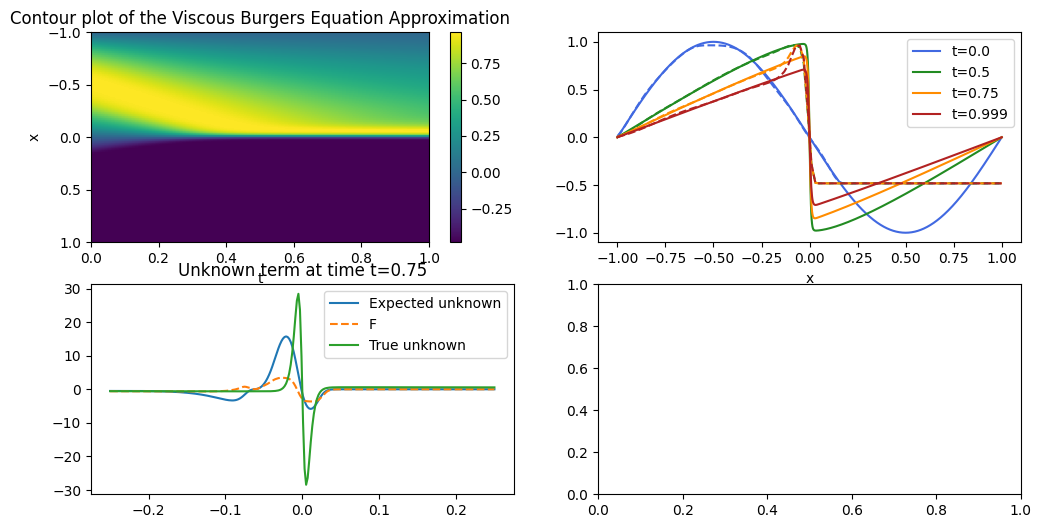

Iteration 9001
Iteration 9002
Iteration 9003
Iteration 9004
Iteration 9005
Iteration 9006
Iteration 9007
Iteration 9008
Iteration 9009
Iteration 9010
Iteration 9011
Iteration 9012
Iteration 9013
Iteration 9014
Iteration 9015
Iteration 9016
Iteration 9017
Iteration 9018
Iteration 9019
Iteration 9020
Iteration 9021
Iteration 9022
Iteration 9023
Iteration 9024
Iteration 9025
Iteration 9026
Iteration 9027
Iteration 9028
Iteration 9029
Iteration 9030
Iteration 9031
Iteration 9032
Iteration 9033
Iteration 9034
Iteration 9035
Iteration 9036
Iteration 9037
Iteration 9038
Iteration 9039
Iteration 9040
Iteration 9041
Iteration 9042
Iteration 9043
Iteration 9044
Iteration 9045
Iteration 9046
Iteration 9047
Iteration 9048
Iteration 9049
Iteration 9050
Iteration 9051
Iteration 9052
Iteration 9053
Iteration 9054
Iteration 9055
Iteration 9056
Iteration 9057
Iteration 9058
Iteration 9059
Iteration 9060
Iteration 9061
Iteration 9062
Iteration 9063
Iteration 9064
Iteration 9065
Iteration 9066
Iteration 

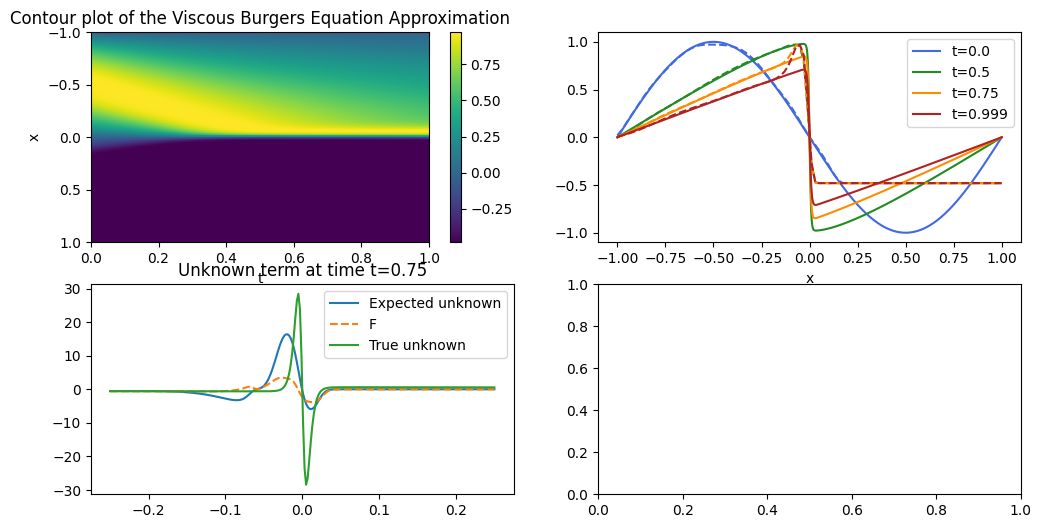

In [23]:
# lr = 2e-2
# optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr) # if you use a shared optimizer
lr_u = 2e-2 #  2e-2
lr_f = 3e-2 #  3e-2
optimizer_u = torch.optim.Adam(u.parameters(), lr=lr_u)
optimizer_f = torch.optim.Adam(f.parameters(), lr=lr_f)

phys_losses = []
losses = []

total_itr = 10001


for i in range(total_itr):
    print(f'Iteration {i}')
#     optimizer.zero_grad()
    optimizer_u.zero_grad()
    optimizer_f.zero_grad()
    
    tot_loss, loss1, loss2, loss3 = get_loss(boundary_points, boundary_targets, 
                                                         collocation_p, 
                                                         train_data, train_targets,
                                                        lambdas=(3e0, 9e0, 5e0)) # 9e0, 2e1, 5e0
    losses.append(tot_loss.item())
    
    tot_loss.backward()
#     optimizer.step()
    optimizer_u.step()
    optimizer_f.step()
    
    if i% 1000 == 0:
        print(f'[{i}/{total_itr}] Boundary L: {loss1.item()}, Phys L: {loss2.item()}, Data L: {loss3.item()}')
        plot_solution(usol, u, f)


In [24]:
# Save models
torch.save(u.state_dict(), './u_burgers_good.pt')
torch.save(f.state_dict(), './f_burgers_good.pt')

#### Use LBFGS optimizer

In [25]:
from torch.optim import LBFGS
lbfgs_optim = LBFGS([*u.parameters(), *f.parameters()], history_size=20, max_iter=10)

In [26]:
def closure():
    lbfgs_optim.zero_grad()
    tot_loss, _, _, _ = get_loss(boundary_points, boundary_targets, 
                                    collocation_p, 
                                    train_data, train_targets,
                                    lambdas=(3e0, 9e0, 5e0)) # 9e0, 2e1, 5e0 # 
    tot_loss.backward()
    return tot_loss

[                    ] 0%[0/10001]


C:\Users\jonas\AppData\Local\Temp\ipykernel_10068\2272388903.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


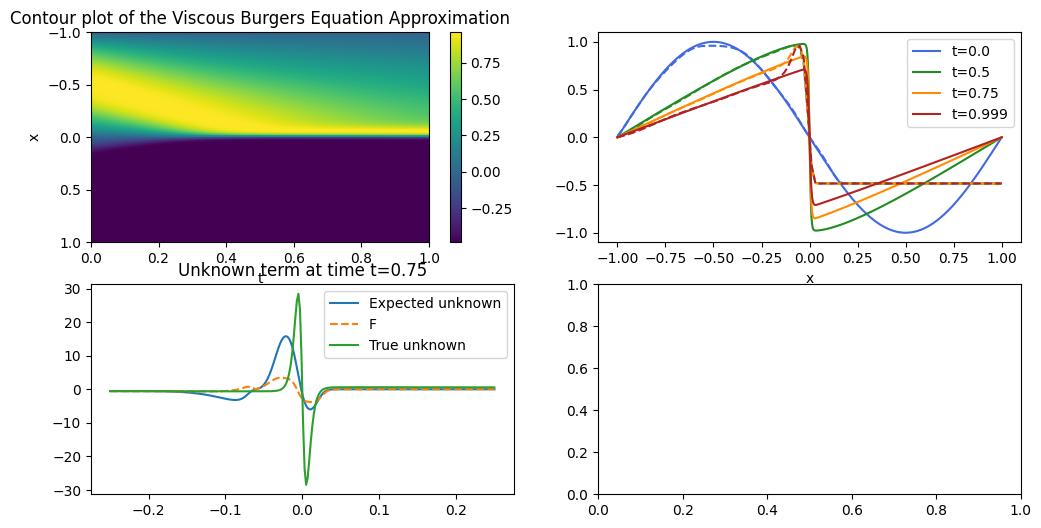

[                    ] 4%

In [ ]:
import sys
lbfgs_itr = 10001


for i in range(lbfgs_itr):
    lbfgs_optim.step(closure)
    sys.stdout.write("\r[%-20s] %d%%" % ('=' * (i // (lbfgs_itr // 20)), (i * 100) // lbfgs_itr))
    sys.stdout.flush()
    
    if i%500 == 0:
        print(f'[{i}/{lbfgs_itr}]')
        fig_lbfgs = plot_solution(usol, u, f)

In [ ]:
# Save models
torch.save(u.state_dict(), './u_burgers_LBFGS_good.pt')
torch.save(f.state_dict(), './f_burgers_LBFGS_good.pt')

In [ ]:
fig_lbfgs.savefig('./burgers_lbfgs_good.pdf')

In [ ]:
# how to: Retrieve the model: 

# u_model = U(2,1, [20]*8)
# checkpoint = torch.load('./path/u_burgers_LBFGS.pt')
# u_model.load_state_dict(checkpoint)# u_model.eval()

# equivalent for f

# try it:
# u_model(torch.Tensor([0,-0.5]))

In [ ]:
# plot_solution(usol, u, f, mesh_size=10**2)

/tmp/ipykernel_14043/2272388903.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


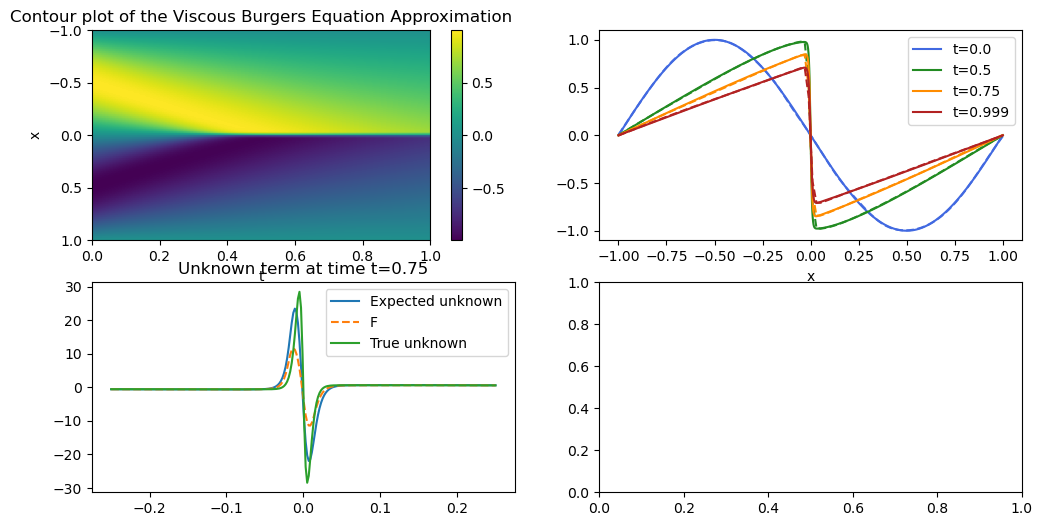

In [ ]:
tmp = plot_solution(usol, u, f,mesh_size=10**2)